In [1]:
import torch
from torch import nn
from torch.autograd import grad
from torch import pi, cos, sin
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.set_default_tensor_type(torch.FloatTensor)
torch.manual_seed(2023)

plt.rcParams['font.size'] = 15

cpu


c:\Users\Max-PC\Documents\Visual Studio Code\.venv\Lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


# of total points:9914


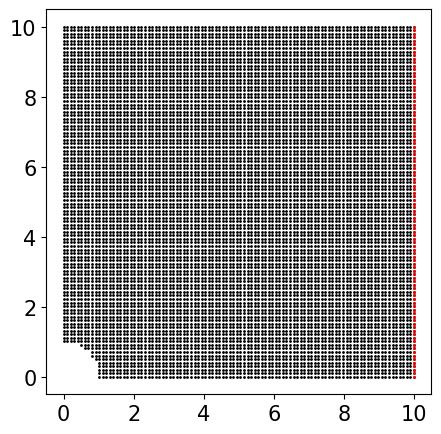

In [3]:
# Geometries
L = 10
r = 1

''' Determine the number of integration points by testing various dx and dy '''
dx = 0.1
dy = 0.1


''' Enter the mechanical properties '''
# Mechanical properties
E = 7*10**4
v = 0.25
P = 1.5
lam = v*E/(1-v**2)
mu = E/(2*(1+v))

# domain points
Nx = int(L/dx)
Ny = int(L/dy)
xv = torch.linspace(0., L, Nx).to(device)
yv = torch.linspace(0., L, Ny).to(device)
xx, yy = torch.meshgrid([xv,yv], indexing='ij')
x = xx.reshape(-1)
y = yy.reshape(-1)
dom = torch.stack([x,y],dim=1)
doi = dom[:,0]**2 + dom[:,1]**2 >= r**2
dom = dom[doi,:]
dom.requires_grad = True

# boundary points
N_surf = Ny
''' Determine x_right and y_right, the size of both is [N_surf X 1] '''
''' Don't forget to assign them to the device '''
y_right = torch.linspace(0, L, N_surf).view(-1, 1).to(device)
x_right = torch.full((N_surf, 1), L, device=device)
right = torch.stack([x_right, y_right], dim=1)
right.requires_grad = True

# Schematics
fig,ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(dom[:,0].detach().cpu().numpy(), dom[:,1].detach().cpu().numpy(), s=1, c='k')
ax.scatter(right[:,0].detach().cpu().numpy(), right[:,1].detach().cpu().numpy(), s=1, c='r')
ax.set_aspect('equal')
print('# of total points:' + str(dom.shape[0]))

In [5]:
# Displacement, strain, stress
def GetU(x):
    u = model(x)
    ''' Enter an appropriate form of displacement field '''
    u[:,0] *= P/E
    u[:,1] *= -v*P/E
    return u

def strain(u, x):
    du = grad(u[:,0].unsqueeze(1), x, torch.ones(x.shape[0],1).to(device), retain_graph=True, create_graph=True)[0]
    dv = grad(u[:,1].unsqueeze(1), x, torch.ones(x.shape[0],1).to(device), retain_graph=True, create_graph=True)[0]
    exx = du[:,0]
    eyy = dv[:,1]
    exy = du[:,1] + dv[:,0]
    e = torch.stack([exx, eyy, exy], dim=1)
    return e

def stress(e):
    exx = e[:,0].unsqueeze(1)
    eyy = e[:,1].unsqueeze(1)
    exy = e[:,2].unsqueeze(1)
    
    sxx = (lam+2*mu)*exx + lam*eyy
    syy = (lam+2*mu)*eyy + lam*exx
    sxy = mu*exy
    s = torch.stack([sxx, syy, sxy], dim=1)
    return s

# Mechanical energy
def strain_energy(e):
    exx = e[:,0]
    eyy = e[:,1]
    exy = e[:,2]
    w = 0.5*lam*(exx+eyy)**2 + mu*(exx**2 + eyy**2 + 0.5*exy**2)
    return w

def IntEnergy(u,x,volume):
    e = strain(u,x)
    psi_int = strain_energy(e)
    U = psi_int.mean() * volume
    return U

def ExtWork(us,area):
    ''' Enter an appropriate form of external work '''
    psi_traction = P*us[:,0]
    W = psi_traction.mean() * area
    return W

In [6]:
# Define model and optimizer
class NN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, num_layers):
        super().__init__()
        self.fcs = nn.ModuleList()
        self.acts = nn.ModuleList()

        for i in range(1, num_layers + 1):
            if i < num_layers:
                out_dim_ = hidden_dim
            else:
                out_dim_ = out_dim

            fc = nn.Linear(in_dim, out_dim_)

            self.fcs.append(fc)
            in_dim = hidden_dim

            if i < num_layers:
                self.acts.append(nn.Tanh())


    def forward(self, x):
        for fc, act in zip(self.fcs, self.acts):
            x = act(fc(x))
        return self.fcs[-1](x)

''' Determine the network configuration and optimizer '''
model = NN(in_dim= 2, out_dim= 2, hidden_dim= 128, num_layers= 4)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
uc = 1e-4 # value to scale the displacement (do not change!)

""" Write the volume of the domain and area of the surface """
volume = (4*L**2-pi*r**2)*1/4
area = (2*L*1)

def train(max_iter):
    R_trace = []
    
    with tqdm(total=max_iter, desc='Training', unit='iter') as pbar:
        for t in range(1, max_iter+1):
            u = uc * GetU(dom)
            
            ''' Enter an appropriate form of surface displacement ''' # Consider the direction carefully.
            us = uc * GetU(right)
            
            U = IntEnergy(u, dom, volume)
            W = ExtWork(us, area)
            R = (U-W)/E # Elastic modulus is too big, so we divide to nondimensionalize. (Do not change!)
            
            R.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

            R_trace.append(R.item())

            if t % 10 == 0:
                pbar.set_postfix(loss=R)
                pbar.update(10)

    return R_trace

''' You may change the number of iterations '''
R_trace = train(5000)
    
fig,ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(range(1, len(R_trace)+1), R_trace, 'b')
ax.set_yscale('symlog')

Training:   0%|          | 0/5000 [00:00<?, ?iter/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x1 and 2x128)

In [ ]:
# x and y coordinates
X = dom[:, 0]
Y = dom[:, 1]
X_np = X.detach().cpu().numpy()
Y_np = Y.detach().cpu().numpy()

''' Obtain the strain and stress '''
u = uc * GetU(dom) 
e = strain(u, dom)
s = stress(e)

u = u.detach().cpu().numpy()
e = e.detach().cpu().numpy()
s = s.detach().cpu().numpy()

''' Write the strain and stress components '''
ux = u[:, 0]
uy = u[:, 1]
u_mag = (ux**2 + uy**2)**0.5

exx = e[:, 0]
eyy = e[:, 1]
exy = e[:, 2]

sxx = s[:, 0]
syy = s[:, 1]
sxy = s[:, 2]


# Plot results

# ux
fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(3, 3, 1)
ax.set_aspect('equal')
ax.set_title('ux', fontdict = {'fontsize' : 30})
plt.scatter(X_np, Y_np, c=ux, s=5, cmap='jet')
plt.colorbar()

# uy
ax = fig.add_subplot(3, 3, 2)
ax.set_aspect('equal')
ax.set_title('uy', fontdict = {'fontsize' : 30})
plt.scatter(X_np, Y_np, c=uy, s=5, cmap='jet')
plt.colorbar()

# u_mag
ax = fig.add_subplot(3, 3, 3)
ax.set_aspect('equal')
ax.set_title('|U|', fontdict = {'fontsize' : 30})
plt.scatter(X_np, Y_np, c=u_mag, s=5, cmap='jet')
plt.colorbar()

''' Plot the distribution of strain and stress components '''

# exx
ax = fig.add_subplot(3, 3, 4)
ax.set_aspect('equal')
ax.set_title('exx', fontdict = {'fontsize' : 30})
plt.scatter()
plt.colorbar()

# eyy
ax = fig.add_subplot(3, 3, 5)
ax.set_aspect('equal')
ax.set_title('eyy', fontdict = {'fontsize' : 30})
plt.scatter()
plt.colorbar()

# exy
ax = fig.add_subplot(3, 3, 6)
ax.set_aspect('equal')
ax.set_title('exy', fontdict = {'fontsize' : 30})
plt.scatter()
plt.colorbar()

# sxx
ax = fig.add_subplot(3, 3, 7)
ax.set_aspect('equal')
ax.set_title('sxx', fontdict = {'fontsize' : 30})
plt.scatter()
plt.colorbar()

# syy
ax = fig.add_subplot(3, 3, 8)
ax.set_aspect('equal')
ax.set_title('syy', fontdict = {'fontsize' : 30})
plt.scatter()
plt.colorbar()

# sxy
ax = fig.add_subplot(3, 3, 9)
ax.set_aspect('equal')
ax.set_title('sxy', fontdict = {'fontsize' : 30})
plt.scatter()
plt.colorbar()